In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from PrepareData import DataPreparer
from GetData import DataPreprocessor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import optuna
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
os.getcwd()
file_path = '/Users/ayoubmarzoug/QRT Datachallenge/Project/'
os.chdir(file_path)

# Data Loading & Preprocessing

In [ ]:
'''train_data_prep = DataPreparer(path = 'data/', save_to_csv=True,train=True)
train_data_prep.prepare_data()
train_data_prep.save_data()

test_data_prep = DataPreparer(path = 'data/', save_to_csv=True,train=False)
test_data_prep.prepare_data()
test_data_prep.save_data()
'''

Saving the prepared data to prepared_train_data.parquet
Saving the prepared data to prepared_train_data.csv
Data prepared and saved!


In [3]:
# Loading Train Data
train_data, features, target = DataPreprocessor(train=True).get_data()

Removed 9.49% of columns because they have more than 20% of values missing
Removed 1.5% of columns because they have only one value
Removed 40.02% of rows because they have missing values


In [4]:
# Loading Test Data
test_data, _, _ = DataPreprocessor(train=False).get_data()
test_data = test_data[features]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data[features], 
	train_data[target], 
	test_size=0.2, 
	random_state=42,
	stratify=train_data[target],
	shuffle=True
	)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction

In [7]:
# Initializing PCA to retain 99% of the variance
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
# Train the Random Forest
# rf = RandomForestClassifier(random_state=42, n_estimators=100)
xgb = XGBClassifier(random_state=42, n_estimators=100)
xgb.fit(X_train_pca, y_train)

print("Training accuracy:", xgb.score(X_train_pca, y_train))
print("Test accuracy:", xgb.score(X_test_pca, y_test))

Training accuracy: 1.0
Test accuracy: 0.4735772357723577


In [9]:
# Feature selection
selector = SelectFromModel(xgb, prefit=True, threshold='1.04*mean')  # Can adjust threshold if needed
X_train_selected = selector.transform(X_train_pca)
X_test_selected = selector.transform(X_test_pca)

# Retrain or evaluate with selected features
xgb_selected = XGBClassifier(random_state=42, n_estimators=100)
xgb_selected.fit(X_train_selected, y_train)
print("Training accuracy:", xgb_selected.score(X_train_selected, y_train))
print("Test accuracy:", xgb_selected.score(X_test_selected, y_test))

Training accuracy: 1.0
Test accuracy: 0.48644986449864497


In [10]:
X_train_selected = pd.DataFrame(X_train_selected)
X_test_selected = pd.DataFrame(X_test_selected)
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

# Model Building

## XGBoost

In [ ]:
# Best for XBG
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be optimized
    params = {
        'objective': 'multi:softmax',  # Objective function for multi-class classification
        'max_depth': trial.suggest_int('max_depth', 3, 12),  # Maximum depth of the trees
        'learning_rate': trial.suggest_float('lr', 0.005, 0.11),  # Learning rate
        'n_estimators': trial.suggest_int('n_estimators', 50, 10000),  # Number of boosting rounds
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),  # Subsample ratio of the training instances
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  # Subsample ratio of columns when constructing each tree
        'gamma': trial.suggest_float('gamma', 0, 9),  # Minimum loss reduction required to make a further partition on a leaf node
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),  # Booster type
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),  # Minimum sum of instance weight (hessian) needed in a child
        'num_class': 3,  # Number of classes
        'eval_metric': 'mlogloss'  # Evaluation metric for multi-class log loss
    }

    # Initialize the XGBoost classifier with the specified hyperparameters
    xgb = XGBClassifier(**params)
    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-mlogloss')  # Pruning callback for early stopping

    mean_accuracy = 0  # Initialize mean accuracy
    cv = StratifiedKFold(n_splits=7, shuffle=False)  # Stratified k-fold cross-validation
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train_pca, y_train)):
        x_train, x_val = X_train_pca.iloc[train_idx], X_train_pca.iloc[val_idx]  # Split training and validation data
        train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]  # Split training and validation labels
        xgb.fit(
            x_train,
            train_y,
            eval_set=[(x_val, val_y)],  # Evaluate on validation data
            early_stopping_rounds=50,  # Stop early if no improvement after 50 rounds
            verbose=0,  # No verbose output
            callbacks=[pruning_callback]  # Include pruning callback
        )

        y_pred = xgb.predict(x_val)  # Make predictions on validation data
        mean_accuracy += accuracy_score(val_y, y_pred)  # Calculate and accumulate accuracy

    return mean_accuracy / 7  # Return average accuracy over all folds

# Create an Optuna study with a pruner for early stopping and direction to maximize accuracy
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
# Optimize the study with 2000 trials and a timeout of 6000 seconds
study.optimize(objective, n_trials=50, timeout=6000)

# Print the number of finished trials
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

# Print the value (accuracy) and parameters of the best trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [12]:
b = {'max_depth': 3, 'lr': 0.09021122911252617, 'n_estimators': 5218, 'subsample': 0.9496538830997062, 'colsample_bytree': 0.8632560541466223, 'gamma': 5.772302064826325, 'booster': 'gbtree', 'min_child_weight': 7}

In [14]:
# Initialize stratified k-fold cross-validation with 7 splits
cv = StratifiedKFold(n_splits=5, shuffle=False)
mean = 0  # Initialize variable to accumulate mean accuracy
results = []  # List to store evaluation results

# Iterate through each fold in the cross-validation split
for i, (train_idx, val_idx) in enumerate(cv.split(X_train_pca, y_train)):
    # Split the data into training and validation sets based on the current fold
    x_train, x_val = X_train_pca.iloc[train_idx], X_train_pca.iloc[val_idx]
    train_y, val_y = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize the XGBoost classifier with the best hyperparameters (b4) and additional parameters
    model = XGBClassifier(**b, num_classes=3, eval_metric=['merror', 'mlogloss'])
    
    # Train the model on the training set and validate on the validation set
    model.fit(
        x_train, train_y,
        eval_set=[(x_train, train_y), (x_val, val_y)],  # Evaluate on both training and validation sets
        early_stopping_rounds=50,  # Stop early if no improvement after 50 rounds
        verbose=0  # No verbose output
    )
    
    # Append the evaluation results to the results list
    results.append(model.evals_result_)
    
    # Make predictions on the validation set
    y_pred = model.predict(x_val)
    
    # Calculate and accumulate the accuracy score
    mean += accuracy_score(val_y, y_pred)

# Calculate the average accuracy over all folds
print(mean / 7)

model = XGBClassifier(**b, num_classes=3)
model.fit(X_train_pca, y_train)

# Make predictions on the test set
ypred = model.predict(X_test_pca)

# Calculate and print the accuracy score on the test set
accuracy_score(ypred, y_test)

0.35805182131119645


0.49525745257452575

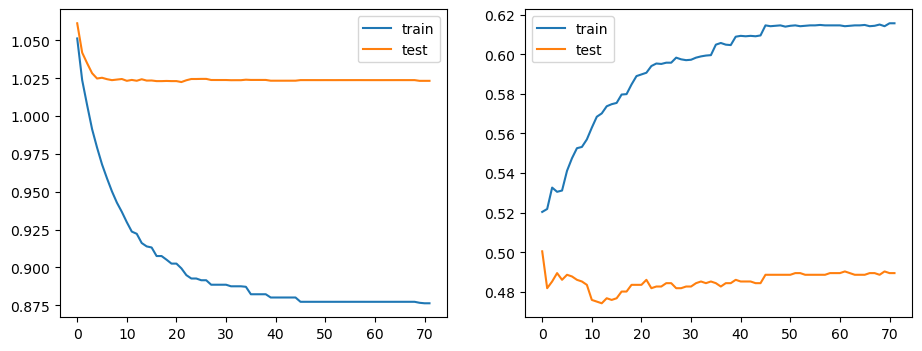

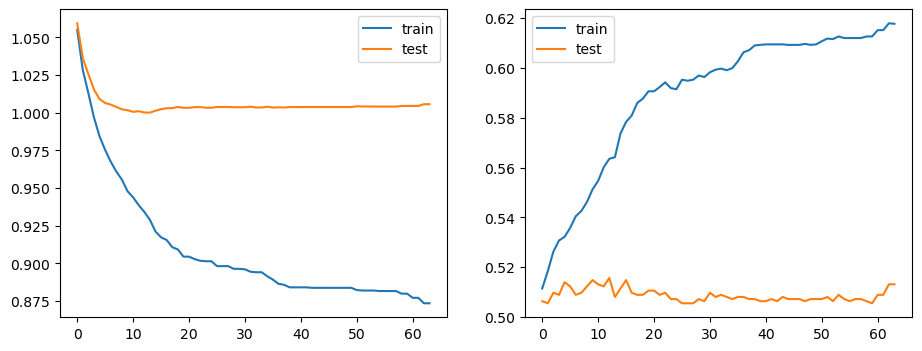

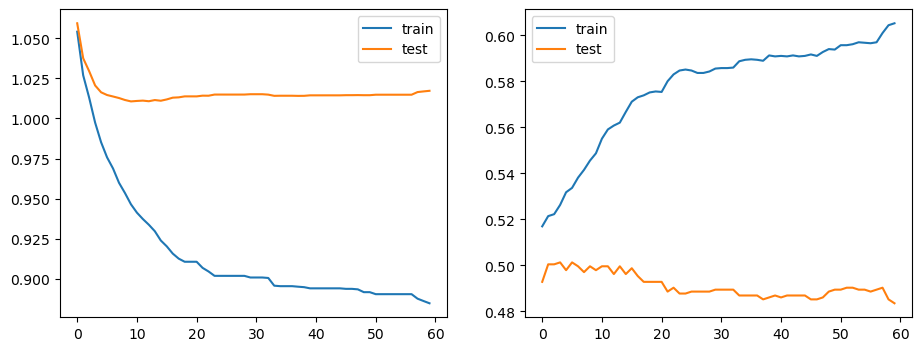

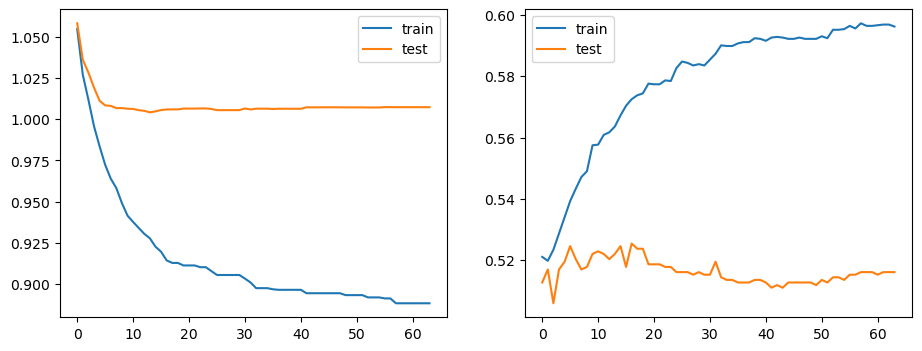

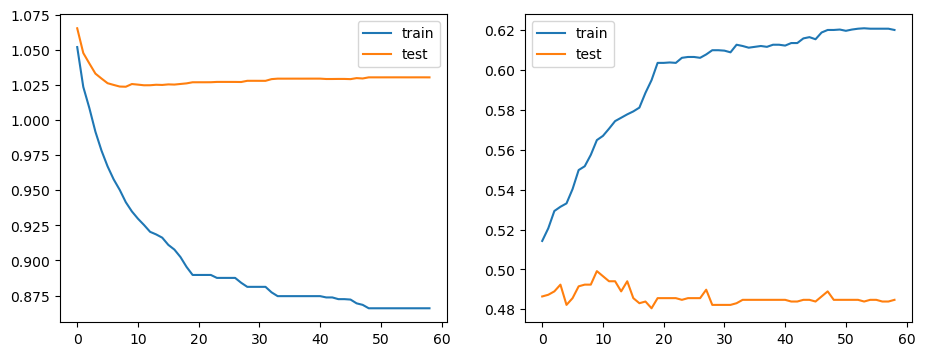

In [17]:
# Plot log loss and accuracy for training and validation sets
# results = model.evals_result_
for result in results:
    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].plot(result['validation_0']['mlogloss'], label='train')
    ax[0].plot(result['validation_1']['mlogloss'], label='test')
    ax[1].plot((np.ones_like(result['validation_0']['merror'])-result['validation_0']['merror']), label='train')
    ax[1].plot((np.ones_like(result['validation_0']['merror'])-result['validation_1']['merror']), label='test')
    ax[0].legend()
    ax[1].legend()
plt.show()

## MLP

In [30]:
X_train_selected = X_train_selected.to_numpy() if hasattr(X_train_selected, 'to_numpy') else X_train_selected
X_test_selected = X_test_selected.to_numpy() if hasattr(X_test_selected, 'to_numpy') else X_test_selected

# Define feature_columns
feature_columns = X_train_selected.shape[1]  # number of features

def create_model(layer1=160, layer2=896, dropout_rate=0.15, l2_strength=0.001607168503200792, learning_rate=0.00001):
    model = Sequential()
    model.add(Dense(
        layer1, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(l2_strength), 
        input_dim=feature_columns
    ))
    model.add(Dense(
        layer2, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(l2_strength)
    ))
    model.add(Dropout(dropout_rate))   
    model.add(Dense(3, activation='softmax')) 
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# hyperparams
layer1 = 160
layer2 = 896
dropout_rate = 0.15
l2_strength = 0.001607168503200792

# creation of the model
model = create_model(
    layer1=layer1,
    layer2=layer2,
    dropout_rate=dropout_rate,
    l2_strength=l2_strength
)

# define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train_selected, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test_selected, y_test), 
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(X_test_selected, y_test)
print(f'Accuracy: {accuracy}')
print(f'Loss: {loss}')

Epoch 1/20
185/185 - 1s - 8ms/step - accuracy: 0.3773 - loss: 1.8716 - val_accuracy: 0.4621 - val_loss: 1.7882
Epoch 2/20
185/185 - 1s - 3ms/step - accuracy: 0.4494 - loss: 1.7905 - val_accuracy: 0.4844 - val_loss: 1.7588
Epoch 3/20
185/185 - 1s - 3ms/step - accuracy: 0.4762 - loss: 1.7613 - val_accuracy: 0.4810 - val_loss: 1.7459
Epoch 4/20
185/185 - 1s - 4ms/step - accuracy: 0.4782 - loss: 1.7456 - val_accuracy: 0.4925 - val_loss: 1.7380
Epoch 5/20
185/185 - 1s - 3ms/step - accuracy: 0.4896 - loss: 1.7367 - val_accuracy: 0.4925 - val_loss: 1.7318
Epoch 6/20
185/185 - 1s - 3ms/step - accuracy: 0.4918 - loss: 1.7275 - val_accuracy: 0.4932 - val_loss: 1.7268
Epoch 7/20
185/185 - 0s - 3ms/step - accuracy: 0.4992 - loss: 1.7215 - val_accuracy: 0.4885 - val_loss: 1.7222
Epoch 8/20
185/185 - 0s - 3ms/step - accuracy: 0.5026 - loss: 1.7127 - val_accuracy: 0.4912 - val_loss: 1.7178
Epoch 9/20
185/185 - 1s - 3ms/step - accuracy: 0.5152 - loss: 1.7030 - val_accuracy: 0.4919 - val_loss: 1.7140
E

Accuracy: 0.5088075995445251

In [32]:
predictions = model.predict(X_test_selected)
predicted_classes = np.argmax(predictions, axis=1) 
print(classification_report(y_test, predicted_classes))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.76      0.61       647
           1       0.44      0.08      0.13       380
           2       0.47      0.48      0.48       449

    accuracy                           0.50      1476
   macro avg       0.48      0.44      0.41      1476
weighted avg       0.48      0.50      0.45      1476



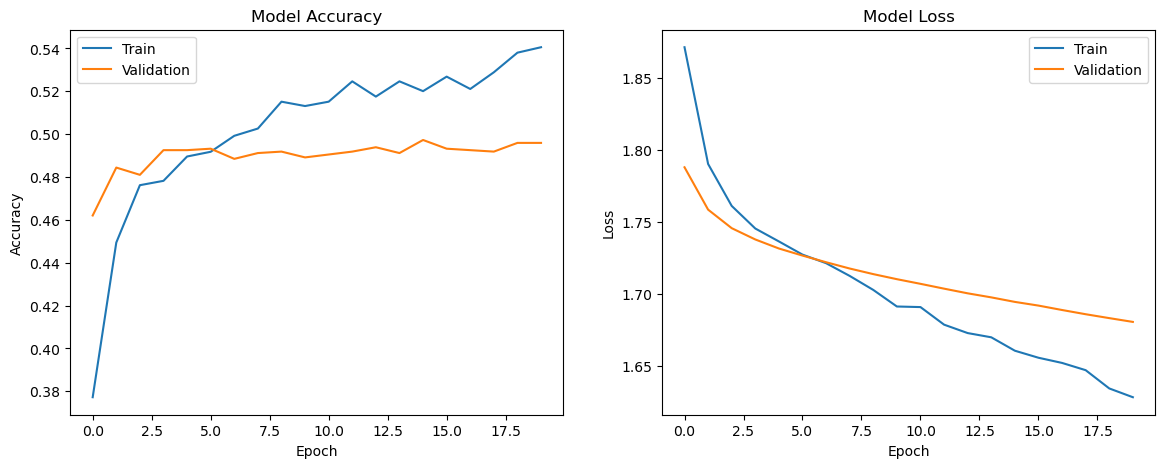

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [34]:
feature_columns = X_train_selected.shape[1]
### construction de la fonction pour optimiser les hyperparamètres
def build_model(hp):
    layer1_units = hp.Int('layer1_units', min_value=32, max_value=1024, step=32)
    layer2_units = hp.Int('layer2_units', min_value=32, max_value=1024, step=32)
    l2_strength = hp.Float('l2_strength', min_value=0.001, max_value=0.1, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.4, default=0.25, step=0.05)
    
    model = Sequential()
    model.add(Dense(layer1_units, activation='relu', kernel_regularizer=regularizers.l2(l2_strength), input_dim=feature_columns))
    model.add(Dense(layer2_units, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    max_trials=20,
    objective="val_accuracy",
    executions_per_trial=1,
    overwrite=True,
    directory="data/test_res",
    project_name="ML_QRT",
)

tuner.search(X_train_selected, y_train, epochs=20, validation_data=(X_test_selected, y_test))

Trial 20 Complete [00h 00m 27s]
val_accuracy: 0.5142276287078857

Best val_accuracy So Far: 0.5155826807022095
Total elapsed time: 00h 08m 01s


Best val_accuracy So Far: 0.5182926654815674


In [19]:
nmodels = 10
best_hyperparameters = tuner.get_best_hyperparameters(nmodels)
evaluation_results = tuner.oracle.get_best_trials(nmodels)
## pour chacun des modèles, on print les hyperparams et son score de validation
for i, (hyperparameters, trial) in enumerate(zip(best_hyperparameters, evaluation_results)):
    accuracy = trial.score
    print(f"Model {i+1}:c")
    print(f"Hyperparameters: {hyperparameters.values}")
    print(f"Score: {round(accuracy, 4)}\n")

Model 1:c
Hyperparameters: {'layer1_units': 32, 'layer2_units': 352, 'l2_strength': 0.02741186175800979, 'dropout_rate': 0.05}
Score: 0.5183

Model 2:c
Hyperparameters: {'layer1_units': 160, 'layer2_units': 1024, 'l2_strength': 0.01057483097998785, 'dropout_rate': 0.4}
Score: 0.5142

Model 3:c
Hyperparameters: {'layer1_units': 224, 'layer2_units': 896, 'l2_strength': 0.002322145336108674, 'dropout_rate': 0.4}
Score: 0.5136

Model 4:c
Hyperparameters: {'layer1_units': 480, 'layer2_units': 672, 'l2_strength': 0.047034195466348155, 'dropout_rate': 0.4}
Score: 0.5088

Model 5:c
Hyperparameters: {'layer1_units': 1024, 'layer2_units': 608, 'l2_strength': 0.0015784283155555192, 'dropout_rate': 0.35000000000000003}
Score: 0.5075

Model 6:c
Hyperparameters: {'layer1_units': 320, 'layer2_units': 480, 'l2_strength': 0.01425289343273275, 'dropout_rate': 0.30000000000000004}
Score: 0.5075

Model 7:c
Hyperparameters: {'layer1_units': 960, 'layer2_units': 448, 'l2_strength': 0.023631867975148046, 'dr

In [20]:
# hyperparams
layer1 = 32
layer2 = 352
dropout_rate = 0.05
l2_strength = 0.02741186175800979

# creation of the model
model = create_model(
    layer1=layer1,
    layer2=layer2,
    dropout_rate=dropout_rate,
    l2_strength=l2_strength
)

# define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

f_m = model.fit(
    X_train_pca, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test_pca, y_test), 
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/20
185/185 - 1s - 6ms/step - accuracy: 0.3419 - loss: 4.3747 - val_accuracy: 0.3509 - val_loss: 4.3131
Epoch 2/20
185/185 - 0s - 1ms/step - accuracy: 0.3868 - loss: 4.2525 - val_accuracy: 0.4011 - val_loss: 4.2086
Epoch 3/20
185/185 - 0s - 1ms/step - accuracy: 0.4227 - loss: 4.1528 - val_accuracy: 0.4160 - val_loss: 4.1190
Epoch 4/20
185/185 - 0s - 1ms/step - accuracy: 0.4430 - loss: 4.0658 - val_accuracy: 0.4363 - val_loss: 4.0346
Epoch 5/20
185/185 - 0s - 1ms/step - accuracy: 0.4572 - loss: 3.9815 - val_accuracy: 0.4492 - val_loss: 3.9534
Epoch 6/20
185/185 - 0s - 1ms/step - accuracy: 0.4587 - loss: 3.9032 - val_accuracy: 0.4539 - val_loss: 3.8743
Epoch 7/20
185/185 - 0s - 1ms/step - accuracy: 0.4659 - loss: 3.8231 - val_accuracy: 0.4634 - val_loss: 3.7974
Epoch 8/20
185/185 - 0s - 1ms/step - accuracy: 0.4754 - loss: 3.7468 - val_accuracy: 0.4668 - val_loss: 3.7223
Epoch 9/20
185/185 - 0s - 1ms/step - accuracy: 0.4767 - loss: 3.6755 - val_accuracy: 0.4695 - val_loss: 3.6491
E

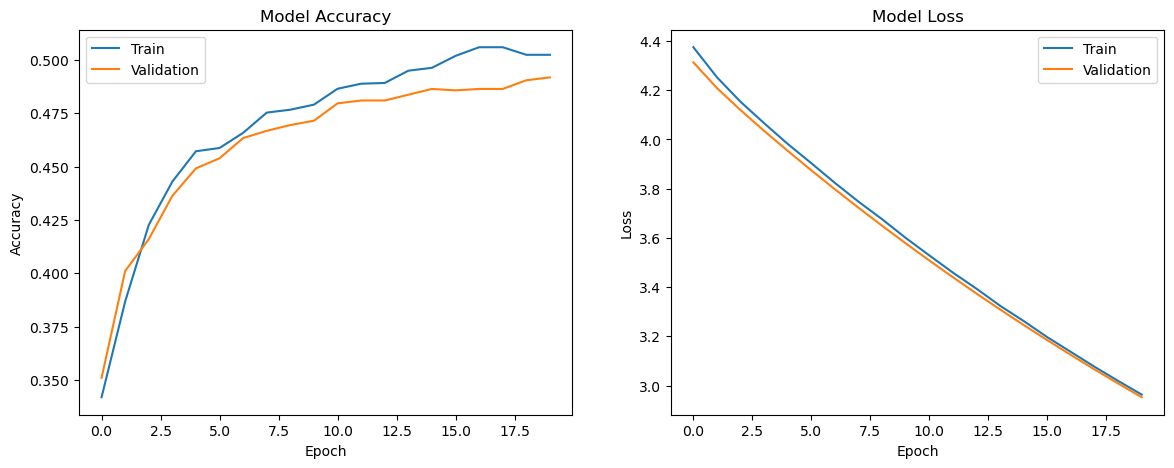

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(f_m.history['accuracy'])
ax1.plot(f_m.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(f_m.history['loss'])
ax2.plot(f_m.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.show()

# Prediction & Submission

In [22]:
# Impute missing values in the test data using the KNNImputer
from sklearn.impute import KNNImputer

neighbor_imputer = KNNImputer(n_neighbors=200).fit(train_data[features])
index = test_data.index
test_data = neighbor_imputer.transform(test_data)

In [23]:
test_data = pca.transform(test_data)

In [28]:
class_predictions = np.argmax(predictions, axis=1)
submission = np.zeros((predictions.shape[0], 3))
submission[np.arange(predictions.shape[0]), class_predictions] = 1
submission = pd.DataFrame(submission, columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'], index=index)
submission.to_csv('../submissions/submission.csv', index=True)